In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import json
import os
import re
import cv2
import h5py
import sys
import time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.__version__

'1.5.0'

In [30]:
# defining different variables
data_dir = '../data/NIST19_combined/'
img_width = 140
img_height = 28
timesteps_size = 140
num_hidden_units = 256
num_classes = 63

# reading the maps
label_cls_name_map = {}
label_name_cls_map = {}
with open('ocr_checkpoints/label_cls_name.json', 'r') as f:
    label_cls_name_map = json.loads(f.read())
    
for k,v in label_cls_name_map.iteritems():
    label_name_cls_map[v] = k

In [26]:
# train dataset inputs and targets
train_inputs = []
train_targets = []
train_image_names = os.listdir(os.path.join(data_dir,'train_images'))
train_df = pd.read_csv(os.path.join(data_dir, 'ocr_combined_train_annotations.csv'))
for train_image_name in train_image_names:
    full_image_path = os.path.join(os.path.join(data_dir, 'train_images'), train_image_name)
    image_np = cv2.imread(full_image_path, 0) # reading the image as 1 channel
    image_np = cv2.resize(image_np, (img_width, img_height), interpolation = cv2.INTER_AREA).T
    train_inputs.append(image_np)
    # get the target
    target_ = ''.join(train_df[train_df['filename']==train_image_name]['class'].tolist())
    train_targets.append(target_)
    
# test dataset inputs and targets
test_inputs = []
test_targets = []
test_image_names = os.listdir(os.path.join(data_dir,'test_images'))
test_df = pd.read_csv(os.path.join(data_dir, 'ocr_combined_test_annotations.csv'))
for test_image_name in test_image_names:
    full_image_path = os.path.join(os.path.join(data_dir, 'test_images'), test_image_name)
    image_np = cv2.imread(full_image_path, 0)
    image_np = cv2.resize(image_np, (img_width, img_height), interpolation = cv2.INTER_AREA).T
    test_inputs.append(image_np)
    # get the target
    target_ = ''.join(test_df[test_df['filename']==test_image_name]['class'].tolist())
    test_targets.append(target_)

train_inputs_ = np.array(train_inputs)
train_targets_ = np.array(train_targets)
test_inputs_ = np.array(test_inputs)
test_targets_ = np.array(test_targets)
print 'Data loaded successfully !!!'

Data loaded successfully !!!


In [27]:
print(train_inputs_.shape)

(20000, 140, 28)


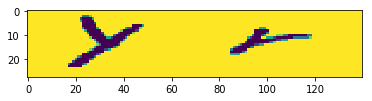

In [29]:
plt.imshow(train_inputs_[0].T)

In [31]:
print train_inputs_.shape
print train_targets_.shape
print test_inputs_.shape
print test_targets_.shape

(20000, 140, 28)
(20000,)
(2000, 140, 28)
(2000,)


## Convert labels into sparse matrix for CTC Loss

yr


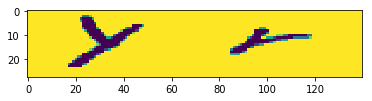

In [34]:
plt.imshow(train_inputs_[0].T)
print train_targets_[0]

In [36]:
def convert_labels_to_integer(labels):
    labels_list = list(labels)
    int_labels_list = map(lambda x: int(label_name_cls_map[x]), labels_list)
    return int_labels_list

train_targets_integer = map(convert_labels_to_integer, train_targets_)
test_targets_integer = map(convert_labels_to_integer, test_targets_)

In [37]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

In [38]:
def decode_sparse_tensor(sparse_tensor):
    """Transform sparse to sequences ids."""
    decoded_indexes = list()
    current_i = 0
    current_seq = []
    for offset, i_and_index in enumerate(sparse_tensor[0]):
        i = i_and_index[0]
        if i != current_i:
            decoded_indexes.append(current_seq)
            current_i = i
            current_seq = list()
        current_seq.append(offset)
    decoded_indexes.append(current_seq)

    result = []
    for index in decoded_indexes:
        ids = [sparse_tensor[1][m] for m in index]
        text = ''.join(list(map(id2word, ids)))
        result.append(text)
    return result
    
def id2word(idx):
    return str(idx)

def hit(text1, text2):
    """Calculate accuracy of predictive text and target text."""
    res = []
    for idx, words1 in enumerate(text1):
        res.append(words1 == text2[idx])
    return np.mean(np.asarray(res))

In [42]:
print train_targets_integer[0]

[4, 57]


In [43]:
train_seq_len = [timesteps_size]*train_inputs_.shape[0] 
test_seq_len = [timesteps_size]*test_inputs_.shape[0] 

## MODEL LSTM + CTC

In [ ]:
num_epochs = 200
num_examples = train_inputs_.shape[0]
batch_size=9
num_batches_per_epoch = num_examples/batch_size
num_layers = 2

graph  = tf.Graph()
with graph.as_default():
    # batch_size x step_size x element_size
    inputs = tf.placeholder(tf.float32, [None, timesteps_size, img_height])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, [None])
    cellS = []
    for i in range(num_layers):
        cell_ = tf.contrib.rnn.LSTMCell(num_hidden_units)
        cells.append(cell_)
    stack = tf.contrib.rnn.MultiRNNCell(cells,state_is_tuple=True)
    
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)
    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]
    # batch_size * timesteps x hidden_layer_size
    outputs = tf.reshape(outputs, [-1, num_hidden_units])
    
    W = tf.Variable(tf.truncated_normal([num_hidden_units, num_classes], stddev=0.1))
    b = tf.Variable(tf.constant(0., shape=[num_classes]))
    logits = tf.matmul(outputs, W) + b
    logits = tf.reshape(logits, [batch_s, -1, num_classes])
    logits = tf.transpose(logits, (1, 0, 2))
    
    loss = tf.nn.ctc_loss(targets, logits, seq_len)
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)   
    
    decoded, _ = tf.nn.ctc_beam_search_decoder(logits, seq_len, merge_repeated=False)
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32), targets))
    
    session =  tf.Session()

    # Initializate the weights and biases
    session.run(tf.global_variables_initializer())
    
    for curr_epoch in range(num_epochs):
        train_cost = train_ler = 0
        start = time.time()

        for batch in range(num_batches_per_epoch-1):
            sparse_train_targets = sparse_tuple_from(train_targets_integers[batch*batch_size :(batch+1)*batch_size])
            
            feed = {inputs: train_inputs_[batch*batch_size :(batch+1)*batch_size],
                    targets: sparse_train_targets,
                    seq_len: train_seq_len[batch*batch_size :(batch+1)*batch_size]}

            batch_cost, _, decoded = session.run([cost, optimizer, decoded], feed)
            train_cost += batch_cost*batch_size
            train_ler += session.run(ler, feed_dict=feed)*batch_size
            
            ori = decode_sparse_tensor(sparse_train_targets)
            pre = decode_sparse_tensor(decoded[0])
            acc = hit(pre, ori)
            
        train_cost /= num_examples
        train_ler /= num_examples

        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, accuracy: {:.4f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler, acc, time.time() - start))
        

In [ ]:

# Replacing blank label to none
str_decoded = str_decoded.replace(chr(ord('z') + 1), '')
# Replacing space label to space
str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

print('Original:\n%s' % original)
print('Decoded:\n%s' % str_decoded)